# Teledetekcja niskiego pułapu

Author: Paweł Burdziakowski, dr inż.
Afiliacja: Politechnika Gdańska

Wersja: 0.1

Opis:
Obróbka danych teledetekcyjnych z kamery Micrasense


In [16]:
import cv2 #openCV
import exiftool
import os, glob
import numpy as np
import pyzbar.pyzbar as pyzbar
import matplotlib.pyplot as plt
import mapboxgl
import math

from micasense.image import Image
import micasense.plotutils as plotutils
import micasense.metadata as metadata
import micasense.utils as msutils
import micasense.capture as capture


if os.name == 'nt':
    if os.environ.get('exiftoolpath') is None:
        print("Set the `exiftoolpath` environment variable as described above")
    else:
        if not os.path.isfile(os.environ.get('exiftoolpath')):
            print("The provided exiftoolpath isn't a file, check the settings")

try:
    with exiftool.ExifTool(os.environ.get('exiftoolpath')) as exift:
        print('Successfully executed exiftool.')
except Exception as e:
    print("Exiftool isn't working. Double check that you've followed the instructions above.")
    print("The execption text below may help to find the source of the problem:")
    print()
    print(e)

Successfully executed exiftool.


In [17]:
%matplotlib inline

imagePath = os.path.join('.','data','Wisla','za','000')
imageNames = glob.glob(os.path.join(imagePath,'IMG_0011_*.tif'))


## Odczyt danych meta ze zdjęcia

In [22]:
exiftoolPath = None
if os.name == 'nt':
    exiftoolPath = 'C:/anaconda3/exiftool.exe'
# get image metadata
meta = metadata.Metadata(imageNames[4], exiftoolPath=exiftoolPath)
cameraMake = meta.get_item('EXIF:Make')
cameraModel = meta.get_item('EXIF:Model')
firmwareVersion = meta.get_item('EXIF:Software')
bandName = meta.get_item('XMP:BandName')
print('{0} {1} firmware version: {2}'.format(cameraMake, 
                                             cameraModel, 
                                             firmwareVersion))
print('Exposure Time: {0} seconds'.format(meta.get_item('EXIF:ExposureTime')))
print('Imager Gain: {0}'.format(meta.get_item('EXIF:ISOSpeed')/100.0))
print('Size: {0}x{1} pixels'.format(meta.get_item('EXIF:ImageWidth'),meta.get_item('EXIF:ImageHeight')))
print('Band Name: {0}'.format(bandName))
print('Center Wavelength: {0} nm'.format(meta.get_item('XMP:CentralWavelength')))
print('Bandwidth: {0} nm'.format(meta.get_item('XMP:WavelengthFWHM')))
print('Capture ID: {0}'.format(meta.get_item('XMP:CaptureId')))
print('Flight ID: {0}'.format(meta.get_item('XMP:FlightId')))
print('Focal Length: {0}'.format(meta.get_item('XMP:FocalLength')))


MicaSense RedEdge-M firmware version: v6.0.1
Exposure Time: 0.0012375 seconds
Imager Gain: 1.0
Size: 1280x960 pixels
Band Name: Red edge
Center Wavelength: 717 nm
Bandwidth: 10 nm
Capture ID: zebsd2zVKK8mhQVkmA8I
Flight ID: nFX3m2vKWQpfTiM6DOUg
Focal Length: None


## Pokaż serię obrazów - radiancja

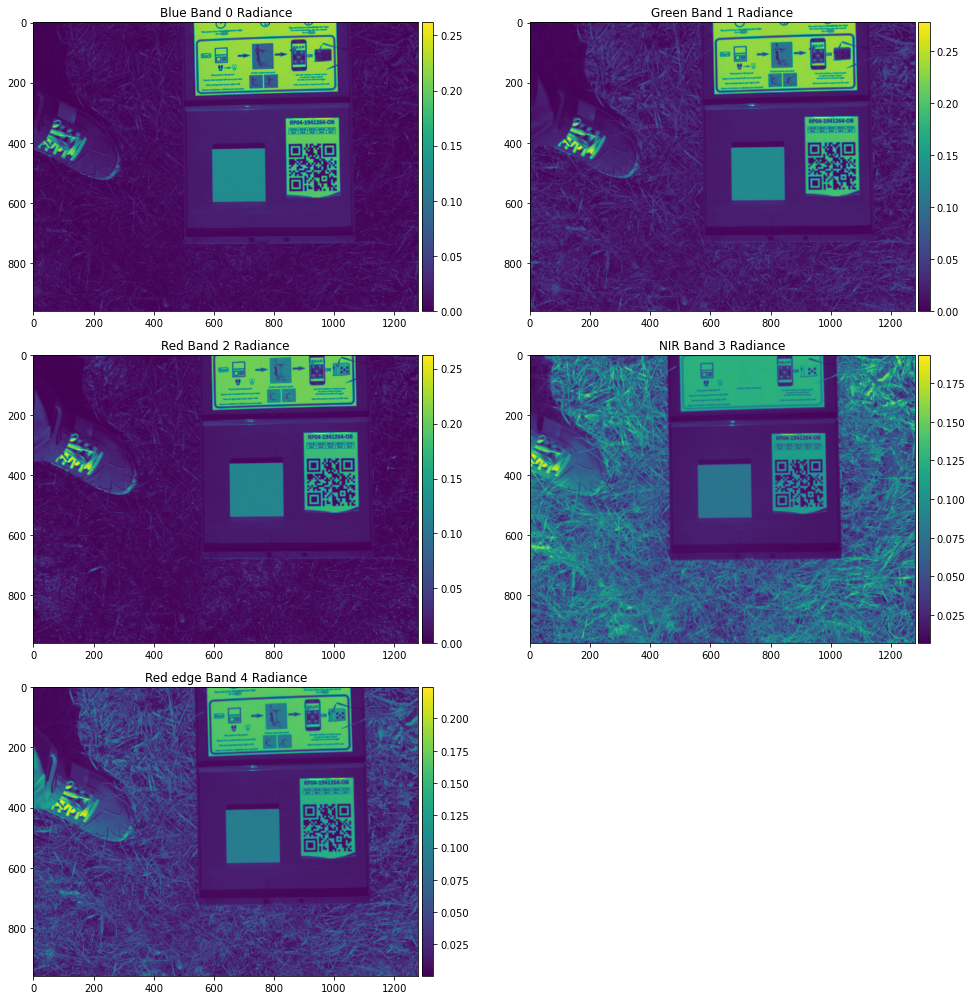

In [20]:
cap = capture.Capture.from_filelist(imageNames)
cap.plot_radiance();

## Dostęp do danych meta

Metadane, które są wspólne dla wszystkich ujęć, mogą być pobrane za pomocą metody 'capture' na obiekcie przechwytywania. 
Metadane, które różnią się między obrazami, takie jak informacje z DLS, są dostępne jako listy dostępne z obiektu zrzutu.

Uwaga: Listy zwracane z dostępu do metadanych na obiekcie są zwracane w kolejności `band_index`. Wszystkie obrazy w ramach zrzutu są sortowane według obrazu `band_index`, a wszystkie listy trzymają się tej kolejności. Kolejność ta jest zgodna z numerem na końcu każdej nazwy pliku obrazu RedEdge.

Poniżej wykreślamy surowe i skompensowane z DLS irradiancję według długości fali środkowej i nazwy pasma.

['Blue', 'Green', 'Red', 'NIR', 'Red edge']


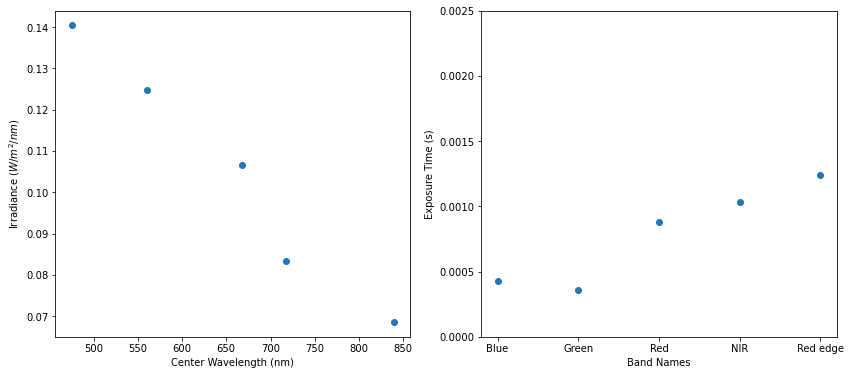

In [23]:
print(cap.band_names())
fig = plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(cap.center_wavelengths(), cap.dls_irradiance())
plt.ylabel('Irradiance $(W/m^2/nm)$')
plt.xlabel('Center Wavelength (nm)')
plt.subplot(1,2,2)
plt.scatter(cap.band_names(), [img.meta.exposure() for img in cap.images])
plt.xlabel('Band Names')
plt.ylim([0,2.5e-3])
plt.ylabel('Exposure Time (s)')
plt.show()